# Import libraries

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from PIL import Image
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, GlobalMaxPooling2D, Conv2DTranspose
from sklearn.model_selection import train_test_split

# Define Variables


In [ ]:
epochs = 50
batch_size = 64

img_height = 296
img_width = 296

# Load dataset

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def display_images(image_list, num_images=5):
  plt.figure(figsize=(15, 5))
  for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image_list[i])
    plt.axis('off')
  plt.show()

<ipython-input-5-75eccac24429>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((img_height, img_width), Image.ANTIALIAS)


430
(296, 296, 3)


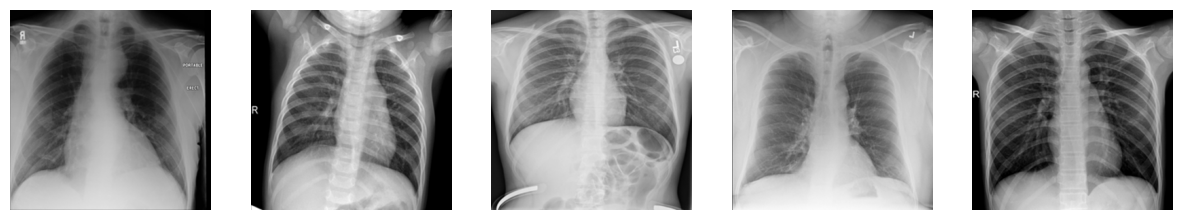

In [ ]:
normal_dir = pathlib.Path("/content/drive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15/normal")
covid_dir = pathlib.Path("/content/drive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15/covid")

def load_images_as_np(folder_path):
  image_list = []
  for filename in os.listdir(folder_path):
    img_path = os.path.join(folder_path, filename)

    img = Image.open(img_path).convert("RGB") #convert to grayscale

    # Just converting to grayscale makes the image turn green,
    # Turn back to RGB to preserve grayscale
    # img = np.array(img)
    # img = Image.fromarray(img).convert("RGB")

    img = img.resize((img_height, img_width), Image.ANTIALIAS)
    img = np.array(img)

    image_list.append(img)
  return image_list

normal_data = load_images_as_np(normal_dir)
covid_data = load_images_as_np(covid_dir)

dataset = normal_data + covid_data

print(len(dataset))
print(dataset[0].shape)

display_images(dataset)

(387, 296, 296, 3)
(43, 296, 296, 3)


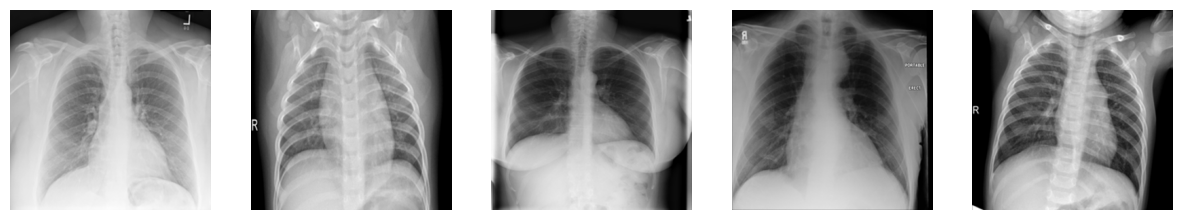

In [ ]:
labels = [0] * len(normal_data) + [1] * len(covid_data)

xtrain, xtest, _, _ = train_test_split(
    dataset, labels, test_size=0.1, random_state=2001173
)

xtrain = np.array(xtrain, dtype=np.float32)
xtest = np.array(xtest, dtype=np.float32)

xtrain /= 255.
xtest /= 255.

print(xtrain.shape)
print(xtest.shape)

display_images(xtest)

# Create Autoencoder model

In [ ]:
class Autoencoder(Model):
  def __init__(self, dim):
    super(Autoencoder, self).__init__()
    self.dim = dim
    self.encoder = Sequential([
      Flatten(),
      Dense(32, activation = 'relu'),
      Dense(32, activation = 'relu'),
      Dense(16, activation = 'relu'),
      Dense(16, activation = 'relu'),
      Dense(16, activation = 'relu'),
      Dense(16, activation = 'relu'),
      Dense(16, activation = 'relu')
    ])
    self.decoder = Sequential([
      Dense(8, activation = 'relu'),
      Dense(16, activation = 'relu'),
      Dense(16, activation = 'relu'),
      Dense(16, activation = 'relu'),
      Dense(16, activation = 'relu'),
      Dense(16, activation = 'relu'),
      Dense(296 * 296 * 3, activation='sigmoid'),
      Reshape((img_height, img_width, 3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(30)

In [ ]:
autoencoder.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = ['accuracy']
)

In [ ]:
history = autoencoder.fit(
    xtrain,
    xtrain,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (xtest, xtest)
)

Epoch 1/50
7/7 [==============================] - 6s 113ms/step - loss: 0.0498 - accuracy: 0.3350 - val_loss: 0.0529 - val_accuracy: 0.3341
Epoch 2/50
7/7 [==============================] - 0s 56ms/step - loss: 0.0479 - accuracy: 0.3343 - val_loss: 0.0396 - val_accuracy: 0.3343
Epoch 3/50
7/7 [==============================] - 0s 55ms/step - loss: 0.0301 - accuracy: 0.3348 - val_loss: 0.0337 - val_accuracy: 0.3295
Epoch 4/50
7/7 [==============================] - 0s 59ms/step - loss: 0.0273 - accuracy: 0.3299 - val_loss: 0.0328 - val_accuracy: 0.3285
Epoch 5/50
7/7 [==============================] - 0s 55ms/step - loss: 0.0256 - accuracy: 0.3291 - val_loss: 0.0325 - val_accuracy: 0.3349
Epoch 6/50
7/7 [==============================] - 0s 58ms/step - loss: 0.0250 - accuracy: 0.3354 - val_loss: 0.0325 - val_accuracy: 0.3355
Epoch 7/50
7/7 [==============================] - 0s 58ms/step - loss: 0.0249 - accuracy: 0.3343 - val_loss: 0.0326 - val_accuracy: 0.3345
Epoch 8/50
7/7 [==========

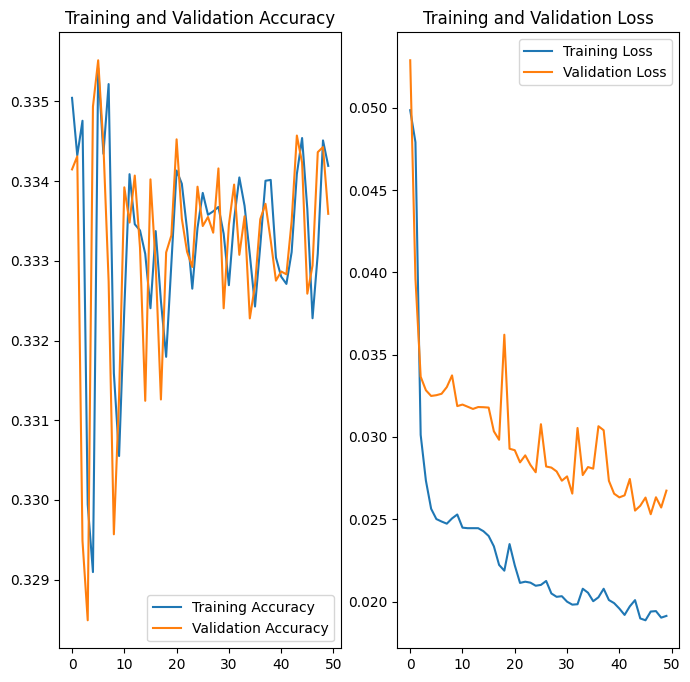

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Convolutional Autoencoder

In [ ]:
channels = 3

class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Sequential([
      Input(shape=(img_height, img_width, channels)),
      Conv2D(32, (3, 3), activation='relu', padding='same'),
      MaxPooling2D((2, 2), padding='same'),
      Conv2D(16, (3, 3), activation='relu', padding='same'),
      BatchNormalization(),
      MaxPooling2D((2, 2), padding='same')
      ])

    self.decoder = Sequential([
      Conv2D(16, (3, 3), activation='relu', padding='same'),
      Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu', padding='same'),
      Conv2DTranspose(channels, (2, 2), strides=(2, 2), activation='softmax', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
    # return tf.image.resize(decoded, [299, 299])

autoencoder = Autoencoder()

# input_img = Input(shape=(xtrain.shape[1], xtrain.shape[2], 1))
# input_img = Input(shape=(xtrain.shape[1], xtrain.shape[2], xtrain.shape[3]))

# # Encoder
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# print("Layer 1: ", x.shape)
# # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# # x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)
# print("Layer 2: ", encoded.shape)

# # Decoder
# y = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# y = UpSampling2D((2, 2))(y)
# # y = Conv2D(128, (3, 3), activation='relu', padding='same')(y)
# # y = UpSampling2D((2, 2))(y)
# y = Conv2D(16, (3, 3), activation='relu')(y)
# y = UpSampling2D((2, 2))(y)
# decoded = Conv2D(3, (3, 3), activation='softmax', padding='same')(y)
# decoded = tf.image.resize(decoded, [299, 299])

# autoencoder = Model(input_img, decoded)

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    # optimizer = "SGD",
    loss='mse',
    metrics = ['accuracy']
    )

# autoencoder.summary()

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/autoencoder/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = autoencoder.fit(
    xtrain,
    xtrain,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (xtest, xtest),
    callbacks=[model_checkpoint_callback]
)

# autoencoder.load_weights(checkpoint_filepath)

Epoch 1/50
7/7 [==============================] - 1s 113ms/step - loss: 0.0949 - accuracy: 0.0299 - val_loss: 0.0876 - val_accuracy: 0.0429
Epoch 2/50
7/7 [==============================] - 1s 78ms/step - loss: 0.0949 - accuracy: 0.0210 - val_loss: 0.0876 - val_accuracy: 0.0112
Epoch 3/50
7/7 [==============================] - 1s 78ms/step - loss: 0.0949 - accuracy: 0.4967 - val_loss: 0.0876 - val_accuracy: 0.9718
Epoch 4/50
7/7 [==============================] - 1s 81ms/step - loss: 0.0949 - accuracy: 0.1740 - val_loss: 0.0876 - val_accuracy: 0.0879
Epoch 5/50
7/7 [==============================] - 1s 75ms/step - loss: 0.0949 - accuracy: 0.0201 - val_loss: 0.0876 - val_accuracy: 0.1467
Epoch 6/50
7/7 [==============================] - 1s 77ms/step - loss: 0.0949 - accuracy: 0.0220 - val_loss: 0.0876 - val_accuracy: 0.1157
Epoch 7/50
7/7 [==============================] - 1s 77ms/step - loss: 0.0949 - accuracy: 0.0206 - val_loss: 0.0876 - val_accuracy: 0.0942
Epoch 8/50
7/7 [==========

# Model Score

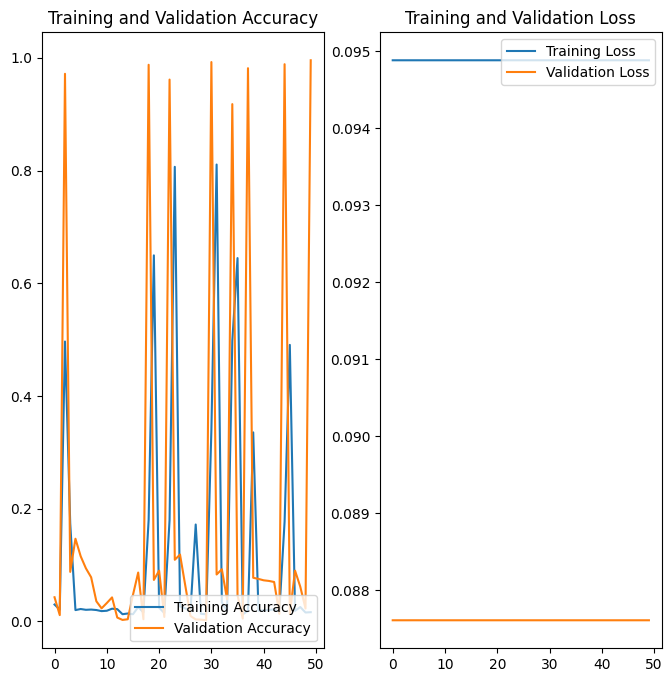

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict

In [ ]:
autoencoder.load_weights('/content/drive/MyDrive/autoencoder/')

loss, acc = autoencoder.evaluate(xtest, xtest, verbose=2)

2/2 - 0s - loss: 0.0876 - accuracy: 0.9958 - 89ms/epoch - 45ms/step


In [ ]:
# predicted = autoencoder.predict(xtest)
# encoded = encoded.reshape((-1, 299, 299))
# print(predicted)

2/2 [==============================] - 0s 12ms/step


In [ ]:
encoded_imgs = autoencoder.encoder(xtest)
decoded_imgs = autoencoder.decoder(encoded_imgs)

# predicted = [Image.fromarray(image*255).convert("L") for image in predicted]

# print(xtest[0])
# print(predicted[0])

# display_images(decoded_imgs)

In [ ]:
def show_imgs(original_imgs, reconstructed_imgs, n=6):
  plt.figure(figsize=(16, 4))
  for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_imgs[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

# def display(array1, array2):
#   """
#   Displays ten random images from each one of the supplied arrays.
#   """

#   n = 10

#   indices = np.random.randint(len(array1), size=n)
#   images1 = array1[indices, :]
#   images2 = array2[indices, :]

#   plt.figure(figsize=(20, 4))
#   for i, (image1, image2) in enumerate(zip(images1, images2)):
#       ax = plt.subplot(2, n, i + 1)
#       plt.imshow(image1.reshape(299, 299, 3))
#       plt.gray()
#       ax.get_xaxis().set_visible(False)
#       ax.get_yaxis().set_visible(False)

#       ax = plt.subplot(2, n, i + 1 + n)
#       plt.imshow(image2.reshape(299, 299, 3))
#       plt.gray()
#       ax.get_xaxis().set_visible(False)
#       ax.get_yaxis().set_visible(False)

#   plt.show()

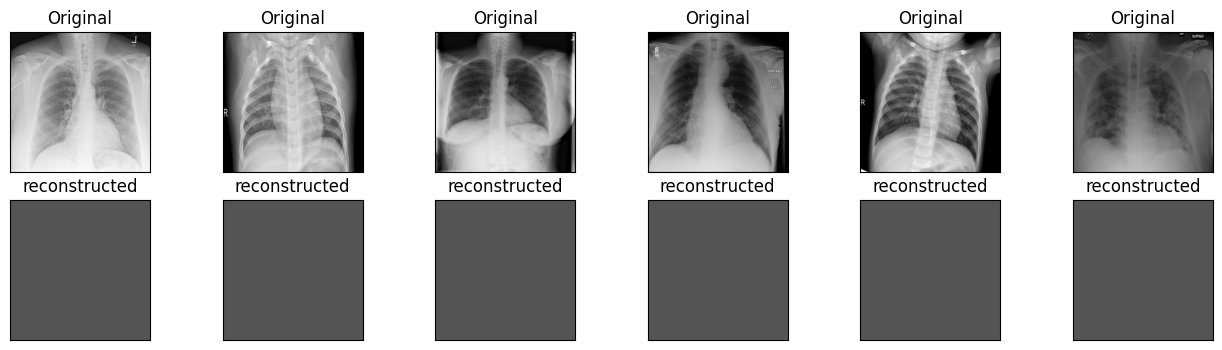

In [ ]:
show_imgs(xtest, decoded_imgs)

#CVAT Dataset

<ipython-input-5-75eccac24429>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((img_height, img_width), Image.ANTIALIAS)


430
(296, 296, 3)
(387, 296, 296, 3)
(43, 296, 296, 3)


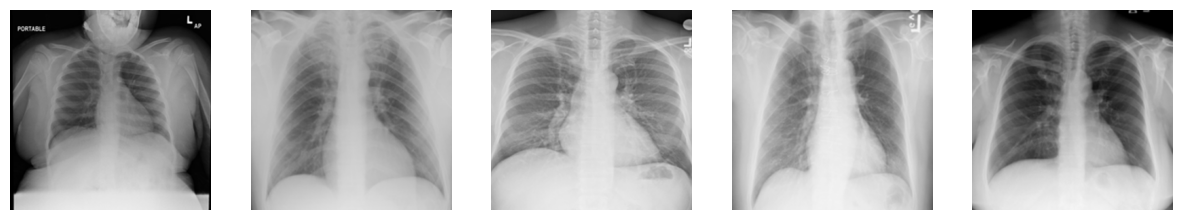

In [ ]:
normal_dir = pathlib.Path("/content/drive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15_cvat/normal")
covid_dir = pathlib.Path("/content/drive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15_cvat/covid")

normal_data = load_images_as_np(normal_dir)
covid_data = load_images_as_np(covid_dir)

dataset = normal_data + covid_data

print(len(dataset))
print(dataset[0].shape)

labels = [0] * len(normal_data) + [1] * len(covid_data)

xtrain, xtest, _, _ = train_test_split(
    dataset, labels, test_size=0.1, random_state=2001173
)

xtrain = np.array(xtrain, dtype=np.float32)
xtest = np.array(xtest, dtype=np.float32)

xtrain /= 255.
xtest /= 255.

print(xtrain.shape)
print(xtest.shape)

display_images(xtest)

img_height = xtrain.shape[1]
img_width = xtrain.shape[2]

In [ ]:
channels = 3

class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Sequential([
      Input(shape=(img_height, img_width, channels)),
      Conv2D(16, (3, 3), activation='relu', padding='same'),
      MaxPooling2D((2, 2), padding='same'),
      # Conv2D(8, (3, 3), activation='relu', padding='same'),
      # MaxPooling2D((2, 2), padding='same'),
      Conv2D(8, (3, 3), activation='relu', padding='same'),
      BatchNormalization(),
      MaxPooling2D((2, 2), padding='same')
      ])

    self.decoder = Sequential([
      Conv2D(8, (3, 3), activation='relu', padding='same'),
      # Conv2DTranspose(8, (2, 2), strides=(2, 2), activation='relu', padding='same'),
      Conv2DTranspose(16, (2, 2), strides=(2, 2), activation='relu', padding='same'),
      Conv2DTranspose(channels, (2, 2), strides=(2, 2), activation='softmax', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder()

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    # optimizer = "SGD",
    loss='mse',
    metrics = ['accuracy']
    )

In [ ]:
history = autoencoder.fit(
    xtrain,
    xtrain,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (xtest, xtest),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
7/7 [==============================] - 4s 136ms/step - loss: 0.0952 - accuracy: 0.2441 - val_loss: 0.0876 - val_accuracy: 0.2028
Epoch 2/50
7/7 [==============================] - 1s 79ms/step - loss: 0.0951 - accuracy: 0.2785 - val_loss: 0.0876 - val_accuracy: 0.3138
Epoch 3/50
7/7 [==============================] - 1s 76ms/step - loss: 0.0951 - accuracy: 0.3104 - val_loss: 0.0876 - val_accuracy: 0.3955
Epoch 4/50
7/7 [==============================] - 1s 76ms/step - loss: 0.0951 - accuracy: 0.3221 - val_loss: 0.0876 - val_accuracy: 0.4603
Epoch 5/50
7/7 [==============================] - 1s 82ms/step - loss: 0.0950 - accuracy: 0.3201 - val_loss: 0.0876 - val_accuracy: 0.5140
Epoch 6/50
7/7 [==============================] - 1s 74ms/step - loss: 0.0950 - accuracy: 0.3312 - val_loss: 0.0876 - val_accuracy: 0.5638
Epoch 7/50
7/7 [==============================] - 1s 79ms/step - loss: 0.0950 - accuracy: 0.3429 - val_loss: 0.0876 - val_accuracy: 0.6112
Epoch 8/50
7/7 [==========

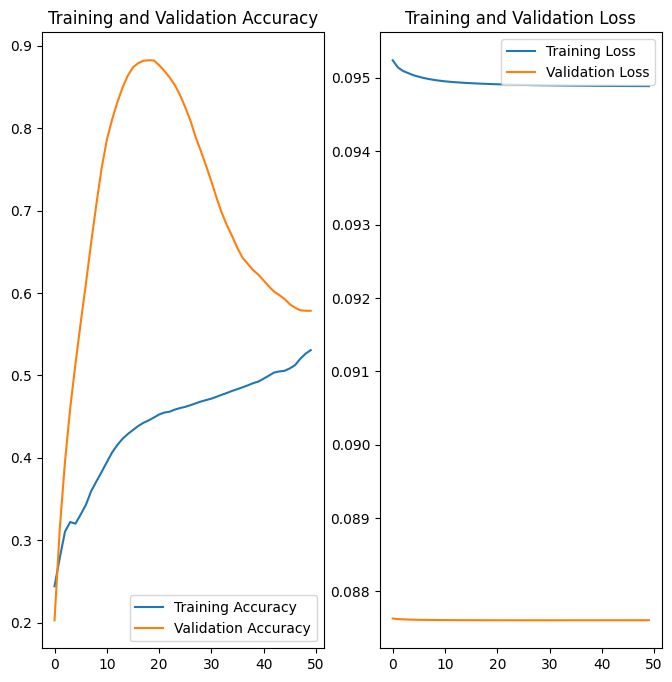

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

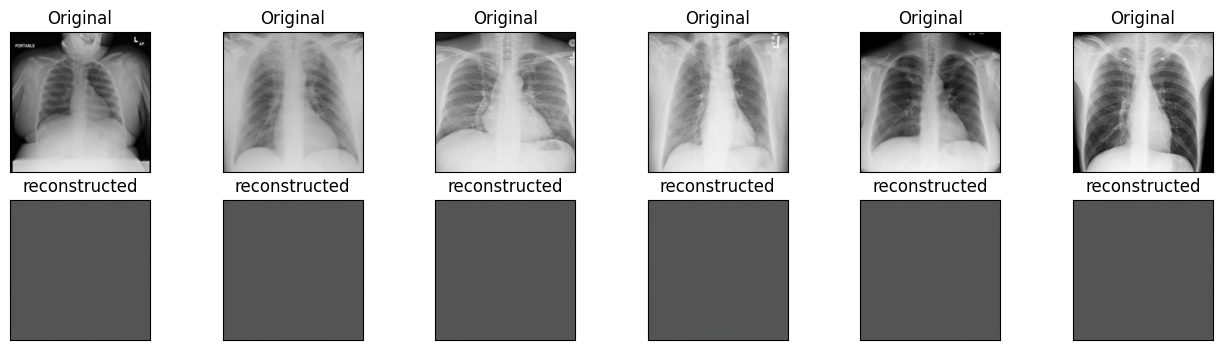

In [ ]:
encoded_imgs = autoencoder.encoder(xtest)
decoded_imgs = autoencoder.decoder(encoded_imgs)

# predicted = [Image.fromarray(image*255).convert("L") for image in predicted]

# print(xtest[0])
# print(predicted[0])

show_imgs(xtest, decoded_imgs)

In [ ]:
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(dataset["train"][i]["pixel_values"].permute(1, 2, 0))
  plt.title(id2label[str(dataset["train"][i]["label"])])
  plt.axis("off")